### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
        image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Gland_Dataset("../gland_data/benq_train_1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Gland_Dataset("../gland_data/benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask = next(iter(test_dataloader))

In [6]:
image.shape

torch.Size([103, 1, 128, 128])

In [7]:
print(len(train_dataset), len(test_dataset))

308 158


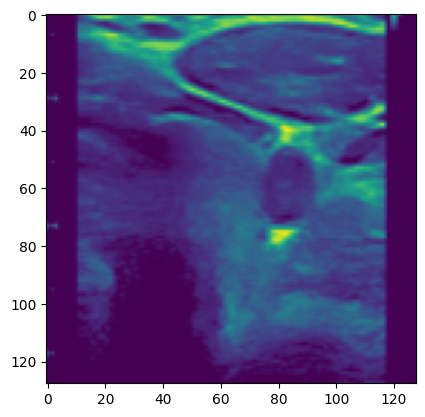

In [8]:
plt.imshow(image[18][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        count+=1
        # if count==5:
        #     break
    return total_loss/count, total_IOU/count, total_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    conut = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        conut += 1
    return total_loss/conut, total_IOU/conut, total_DICE/conut


    

In [10]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [11]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [12]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [13]:

project = "thyroid_gland_finetune"
name = "hybrid_model_gland_baseline(1)_freeze_encoder_wo_zeromask_aug_colorjitter_affine"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [14]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/gland/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/gland/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/gland/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


train loss : 1.1669338742891948, train IOU : 0.4451022446155548, train DICE : 0.6086349487304688


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.7167425751686096, val IOU : 0.5432973802089691, val DICE : 0.7151234149932861
epoch : 1


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.7003448009490967, train IOU : 0.5860211849212646, train DICE : 0.7339668671290079


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.6453402936458588, val IOU : 0.5718306601047516, val DICE : 0.7345071732997894
epoch : 2


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.6523212989171346, train IOU : 0.5972927411397299, train DICE : 0.7422897418340048


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.621004194021225, val IOU : 0.5841929614543915, val DICE : 0.7409069240093231
epoch : 3


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.6022377411524454, train IOU : 0.6272386709849039, train DICE : 0.7588630517323812


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.605552077293396, val IOU : 0.5936387181282043, val DICE : 0.7457894384860992
epoch : 4


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.5322603782018026, train IOU : 0.6567798852920532, train DICE : 0.7733050982157389


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.6052183210849762, val IOU : 0.5961733162403107, val DICE : 0.7434665858745575
epoch : 5


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.5358085831006368, train IOU : 0.6792035698890686, train DICE : 0.7767414848009745


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.5983000099658966, val IOU : 0.5965192019939423, val DICE : 0.7411125600337982
epoch : 6


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.4641766945521037, train IOU : 0.709749698638916, train DICE : 0.7968074480692545


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.5603586882352829, val IOU : 0.60908642411232, val DICE : 0.7454811036586761
epoch : 7


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.4448166986306508, train IOU : 0.7209963798522949, train DICE : 0.8068185448646545


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.5291703194379807, val IOU : 0.6169811487197876, val DICE : 0.7447662353515625
epoch : 8


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.4393633206685384, train IOU : 0.7278815706570944, train DICE : 0.8061804374059042


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.5143069326877594, val IOU : 0.6176291704177856, val DICE : 0.7416254281997681
epoch : 9


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.429572989543279, train IOU : 0.7303566733996073, train DICE : 0.8092872103055319


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.5044809579849243, val IOU : 0.62347611784935, val DICE : 0.7459388077259064
epoch : 10


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.4323645035425822, train IOU : 0.7270818551381429, train DICE : 0.8056416312853495


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.4953988939523697, val IOU : 0.6321543157100677, val DICE : 0.7514731884002686
epoch : 11


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.4006700317064921, train IOU : 0.7527899543444315, train DICE : 0.8208962877591451


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4917822927236557, val IOU : 0.6323305368423462, val DICE : 0.7500489354133606
epoch : 12


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.4243136942386627, train IOU : 0.7386581699053446, train DICE : 0.8058645725250244


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.4894035905599594, val IOU : 0.6290255188941956, val DICE : 0.745285302400589
epoch : 13


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


train loss : 0.38939930001894635, train IOU : 0.755534847577413, train DICE : 0.8265801668167114


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.4859001487493515, val IOU : 0.6292150616645813, val DICE : 0.7418166100978851
epoch : 14


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.3915809194246928, train IOU : 0.7611023187637329, train DICE : 0.8267782131830851


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.478631392121315, val IOU : 0.6322161555290222, val DICE : 0.742719441652298
epoch : 15


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.35916505257288617, train IOU : 0.7721459666887919, train DICE : 0.8344501654307047


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4718325287103653, val IOU : 0.63520947098732, val DICE : 0.7447473704814911
epoch : 16


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.35278141498565674, train IOU : 0.78596959511439, train DICE : 0.8408358097076416


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4695782959461212, val IOU : 0.6344178318977356, val DICE : 0.7440248727798462
epoch : 17


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.36860184868176776, train IOU : 0.7677740653355917, train DICE : 0.832395096619924


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4697866588830948, val IOU : 0.6330409944057465, val DICE : 0.7434396743774414
epoch : 18


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.3412605921427409, train IOU : 0.7814939816792806, train DICE : 0.8416729966799418


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4682633727788925, val IOU : 0.6366573870182037, val DICE : 0.7454924583435059
epoch : 19


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.3410712381203969, train IOU : 0.7911385099093119, train DICE : 0.8482898871103922


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.46704360842704773, val IOU : 0.6433044373989105, val DICE : 0.7494685649871826
epoch : 20


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.32594332098960876, train IOU : 0.7990392843882242, train DICE : 0.8556238015492758


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.46610598266124725, val IOU : 0.6413992047309875, val DICE : 0.7496755719184875
epoch : 21


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.3262849549452464, train IOU : 0.7971201539039612, train DICE : 0.8535895148913065


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4639277160167694, val IOU : 0.6404135227203369, val DICE : 0.7503114342689514
epoch : 22


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.3237091402212779, train IOU : 0.7938088377316793, train DICE : 0.8529971639315287


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.4569312334060669, val IOU : 0.6468203365802765, val DICE : 0.7547657489776611
epoch : 23


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.31033869584401447, train IOU : 0.8059546947479248, train DICE : 0.8620495597521464


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.45314380526542664, val IOU : 0.6534153521060944, val DICE : 0.7593109011650085
epoch : 24


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.3237779140472412, train IOU : 0.7987812757492065, train DICE : 0.8575835625330607


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.4544253647327423, val IOU : 0.6510598063468933, val DICE : 0.7569855749607086
epoch : 25


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.3009284933408101, train IOU : 0.8068416317303976, train DICE : 0.8675912221272787


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4540044665336609, val IOU : 0.6499598026275635, val DICE : 0.7576893270015717
epoch : 26


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.306154986222585, train IOU : 0.8086080749829611, train DICE : 0.8681139945983887


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.44641806185245514, val IOU : 0.6603616178035736, val DICE : 0.7658929824829102
epoch : 27


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.32157432039578754, train IOU : 0.801809291044871, train DICE : 0.8608653942743937


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.44646674394607544, val IOU : 0.6594340801239014, val DICE : 0.7636763453483582
epoch : 28


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.29945162932078045, train IOU : 0.8152738412221273, train DICE : 0.8700269460678101


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.44664372503757477, val IOU : 0.6577989757061005, val DICE : 0.7614812552928925
epoch : 29


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.296137531598409, train IOU : 0.8141472736994425, train DICE : 0.8712154428164164


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.4448244869709015, val IOU : 0.6558188199996948, val DICE : 0.7606560587882996
epoch : 30


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.29652999838193256, train IOU : 0.8133579691251119, train DICE : 0.873036801815033


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4430543780326843, val IOU : 0.6576756834983826, val DICE : 0.7635001838207245
epoch : 31


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.2866413692633311, train IOU : 0.8203229308128357, train DICE : 0.8747253815333048


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.4365167021751404, val IOU : 0.6657739877700806, val DICE : 0.7688909769058228
epoch : 32


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.2868110140164693, train IOU : 0.8236351807912191, train DICE : 0.8778706987698873


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.44067607820034027, val IOU : 0.6604722142219543, val DICE : 0.7652545869350433
epoch : 33


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.28138400117556256, train IOU : 0.8294312159220377, train DICE : 0.8788456718126932


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4399296045303345, val IOU : 0.6606666445732117, val DICE : 0.7654742002487183
epoch : 34


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.28324539462725323, train IOU : 0.8235149383544922, train DICE : 0.8775619665781657


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4284270107746124, val IOU : 0.6736730635166168, val DICE : 0.7757678031921387
epoch : 35


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.287733515103658, train IOU : 0.8191706339518229, train DICE : 0.8711927930514017


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4269355982542038, val IOU : 0.6754639446735382, val DICE : 0.7754530906677246
epoch : 36


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.2832817534605662, train IOU : 0.8279391924540201, train DICE : 0.878397007783254


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.43120838701725006, val IOU : 0.6678711771965027, val DICE : 0.7689564824104309
epoch : 37


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.26118433475494385, train IOU : 0.837008535861969, train DICE : 0.8895488381385803


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.42601795494556427, val IOU : 0.6728836894035339, val DICE : 0.7749055325984955
epoch : 38


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.27983054518699646, train IOU : 0.8236848711967468, train DICE : 0.8829864263534546


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.42446383833885193, val IOU : 0.6722514927387238, val DICE : 0.7752432227134705
epoch : 39


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.2669086853663127, train IOU : 0.8294891715049744, train DICE : 0.8845646778742472


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.41727064549922943, val IOU : 0.6864877641201019, val DICE : 0.7845886647701263
epoch : 40


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.272792528072993, train IOU : 0.8343097766240438, train DICE : 0.8855582078297933


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4216790646314621, val IOU : 0.6826924085617065, val DICE : 0.7834070324897766
epoch : 41


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.2591779828071594, train IOU : 0.8361503481864929, train DICE : 0.8900296886761984


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.42644189298152924, val IOU : 0.6702336370944977, val DICE : 0.7752776443958282
epoch : 42


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.2734437783559163, train IOU : 0.8274392286936442, train DICE : 0.885391116142273


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.41038356721401215, val IOU : 0.688538521528244, val DICE : 0.7868479192256927
epoch : 43


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.2653101235628128, train IOU : 0.8404646913210551, train DICE : 0.8875713149706522


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.40999673306941986, val IOU : 0.686439573764801, val DICE : 0.7856090068817139
epoch : 44


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.2558620472749074, train IOU : 0.8420685529708862, train DICE : 0.8951611717542013


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.4225190579891205, val IOU : 0.6694478094577789, val DICE : 0.7764099836349487
epoch : 45


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.27225860953330994, train IOU : 0.8243887821833292, train DICE : 0.8812161882718405


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.4045266956090927, val IOU : 0.6925600469112396, val DICE : 0.7863081097602844
epoch : 46


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.264792263507843, train IOU : 0.8391101956367493, train DICE : 0.8902989427248637


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.4155101329088211, val IOU : 0.681296169757843, val DICE : 0.7762004137039185
epoch : 47


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.2651289900143941, train IOU : 0.8345955610275269, train DICE : 0.8911512096722921


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.43774519860744476, val IOU : 0.6535344421863556, val DICE : 0.7636829614639282
epoch : 48


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.27083681027094525, train IOU : 0.8324918746948242, train DICE : 0.8875774542490641


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.4064543545246124, val IOU : 0.6876544058322906, val DICE : 0.783401757478714
epoch : 49


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


train loss : 0.2519110639890035, train IOU : 0.8453194300333658, train DICE : 0.8953402638435364


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.3980271816253662, val IOU : 0.6977760791778564, val DICE : 0.7880479097366333
epoch : 50


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.2553365578254064, train IOU : 0.8446757992108663, train DICE : 0.8907012939453125


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.41308023035526276, val IOU : 0.6910759210586548, val DICE : 0.7852039337158203
epoch : 51


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.2546895047028859, train IOU : 0.8426804542541504, train DICE : 0.8963645895322164


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4107844829559326, val IOU : 0.6962571442127228, val DICE : 0.7909394800662994
epoch : 52


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.26094210147857666, train IOU : 0.8344599604606628, train DICE : 0.8903485337893168


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3944075256586075, val IOU : 0.703263521194458, val DICE : 0.7928023338317871
epoch : 53


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.2686367680629094, train IOU : 0.8390106360117594, train DICE : 0.8866140246391296


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.3928496837615967, val IOU : 0.7015717327594757, val DICE : 0.7936132550239563
epoch : 54


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


train loss : 0.24810581902662912, train IOU : 0.8455670674641927, train DICE : 0.8961423436800638


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.4142195135354996, val IOU : 0.683118999004364, val DICE : 0.7846346795558929
epoch : 55


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.24156040946642557, train IOU : 0.8497453729311625, train DICE : 0.898394783337911


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.4187283515930176, val IOU : 0.6841962337493896, val DICE : 0.7818231284618378
epoch : 56


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.24017817278703055, train IOU : 0.8541162808736166, train DICE : 0.9025914470354716


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.4038330614566803, val IOU : 0.7038440704345703, val DICE : 0.7954096496105194
epoch : 57


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.24336491028467813, train IOU : 0.8484868804613749, train DICE : 0.8985217412312826


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.3949715495109558, val IOU : 0.7099155783653259, val DICE : 0.8021644651889801
epoch : 58


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.23756186664104462, train IOU : 0.8484470248222351, train DICE : 0.8990945021311442


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3991657942533493, val IOU : 0.7059747278690338, val DICE : 0.79803067445755
epoch : 59


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.24762777984142303, train IOU : 0.8526076674461365, train DICE : 0.8976869384447733


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3940022885799408, val IOU : 0.7084229588508606, val DICE : 0.798454225063324
epoch : 60


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.23700793087482452, train IOU : 0.8528268933296204, train DICE : 0.9004804491996765


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


val loss : 0.39270608127117157, val IOU : 0.7079056203365326, val DICE : 0.8015139102935791
epoch : 61


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


train loss : 0.23822476466496786, train IOU : 0.8519649306933085, train DICE : 0.9028805692990621


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.40190933644771576, val IOU : 0.7050819098949432, val DICE : 0.8000183999538422
epoch : 62


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.2313933620850245, train IOU : 0.8570847312609354, train DICE : 0.904462734858195


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.40855707228183746, val IOU : 0.6936036646366119, val DICE : 0.7904227077960968
epoch : 63


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.23358645041783652, train IOU : 0.8492904106775919, train DICE : 0.8993909557660421


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3934449702501297, val IOU : 0.708032101392746, val DICE : 0.8010247647762299
epoch : 64


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.24272995193799338, train IOU : 0.8573888540267944, train DICE : 0.8998016516367594


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.3917166590690613, val IOU : 0.7040911614894867, val DICE : 0.798591822385788
epoch : 65


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


train loss : 0.23687869310379028, train IOU : 0.8503393332163492, train DICE : 0.9037345250447592


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.3971283733844757, val IOU : 0.7011749148368835, val DICE : 0.7982218563556671
epoch : 66


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.2398279905319214, train IOU : 0.8513514796892802, train DICE : 0.9032583435376486


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.38484008610248566, val IOU : 0.7198125720024109, val DICE : 0.8083955347537994
epoch : 67


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


train loss : 0.23090972503026327, train IOU : 0.858930766582489, train DICE : 0.9070777893066406


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


val loss : 0.394109770655632, val IOU : 0.6959700286388397, val DICE : 0.7919072806835175
epoch : 68


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.22690284748872122, train IOU : 0.856505811214447, train DICE : 0.9088198741277059


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


val loss : 0.4171549081802368, val IOU : 0.6768919825553894, val DICE : 0.7793033719062805
epoch : 69


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


train loss : 0.2429203192392985, train IOU : 0.853295902411143, train DICE : 0.9026813507080078


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


val loss : 0.39320315420627594, val IOU : 0.7042773067951202, val DICE : 0.7971414625644684
epoch : 70


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.23488359153270721, train IOU : 0.8563419580459595, train DICE : 0.9032235741615295


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.3927598148584366, val IOU : 0.6998714804649353, val DICE : 0.7932443022727966
epoch : 71


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.24229677021503448, train IOU : 0.8532863060633341, train DICE : 0.8995509743690491


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.39259275794029236, val IOU : 0.702842503786087, val DICE : 0.795656830072403
epoch : 72


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.23538586497306824, train IOU : 0.8543316920598348, train DICE : 0.9027203321456909


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


val loss : 0.3899226188659668, val IOU : 0.7075836360454559, val DICE : 0.7999637424945831
epoch : 73


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.2396943916877111, train IOU : 0.8547498981157938, train DICE : 0.9028586149215698


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38974806666374207, val IOU : 0.7092626988887787, val DICE : 0.8009793758392334
epoch : 74


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.23209945360819498, train IOU : 0.8521062135696411, train DICE : 0.9024288058280945


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.39471690356731415, val IOU : 0.7101223170757294, val DICE : 0.7985476553440094
epoch : 75


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.23040293157100677, train IOU : 0.8599110841751099, train DICE : 0.9071334997812907


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.40194153785705566, val IOU : 0.6950215697288513, val DICE : 0.7896274328231812
epoch : 76


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.23033452033996582, train IOU : 0.8561298648516337, train DICE : 0.9040593902269999


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.39621680974960327, val IOU : 0.701637476682663, val DICE : 0.7957746088504791
epoch : 77


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.2416748454173406, train IOU : 0.8514077266057333, train DICE : 0.9032773574193319


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3858773857355118, val IOU : 0.7229560911655426, val DICE : 0.8109638094902039
epoch : 78


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2298519512017568, train IOU : 0.8609044949213663, train DICE : 0.9057251214981079


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.38854438066482544, val IOU : 0.7105033695697784, val DICE : 0.800242692232132
epoch : 79


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.2181280106306076, train IOU : 0.8636617461840311, train DICE : 0.9113912781079611


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3961401879787445, val IOU : 0.698666512966156, val DICE : 0.792735368013382
epoch : 80


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.22225805123647055, train IOU : 0.8659770091374716, train DICE : 0.9115270972251892


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3849201947450638, val IOU : 0.7125115394592285, val DICE : 0.8023936450481415
epoch : 81


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2170413682858149, train IOU : 0.8636187116305033, train DICE : 0.9092397292455038


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3898414522409439, val IOU : 0.7084306478500366, val DICE : 0.7986957430839539
epoch : 82


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2138491372267405, train IOU : 0.864437997341156, train DICE : 0.9134056170781454


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3868658095598221, val IOU : 0.7148066759109497, val DICE : 0.8047269284725189
epoch : 83


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.21878297130266824, train IOU : 0.8677572806676229, train DICE : 0.9118450880050659


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.39196498692035675, val IOU : 0.7053884863853455, val DICE : 0.8010155856609344
epoch : 84


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.22575919330120087, train IOU : 0.858449657758077, train DICE : 0.9075552423795065


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.39334359765052795, val IOU : 0.7065932154655457, val DICE : 0.802198588848114
epoch : 85


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.2231577734152476, train IOU : 0.864759107430776, train DICE : 0.9105111360549927


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3990147113800049, val IOU : 0.7032968699932098, val DICE : 0.794704794883728
epoch : 86


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.22011731068293253, train IOU : 0.8639401396115621, train DICE : 0.9117081761360168


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4029138535261154, val IOU : 0.6945212483406067, val DICE : 0.7924334406852722
epoch : 87


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.21798516313234964, train IOU : 0.8636377652486166, train DICE : 0.9152514735857645


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.39741045236587524, val IOU : 0.7157244384288788, val DICE : 0.8060604333877563
epoch : 88


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.22577805320421854, train IOU : 0.8652318914731344, train DICE : 0.9102276961008707


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3939518928527832, val IOU : 0.7026770710945129, val DICE : 0.7974481582641602
epoch : 89


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.22662868102391562, train IOU : 0.8570131063461304, train DICE : 0.9075416525204977


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3877920061349869, val IOU : 0.7095722556114197, val DICE : 0.8036664724349976
epoch : 90


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.22405043244361877, train IOU : 0.8623588482538859, train DICE : 0.9117994904518127


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3754636198282242, val IOU : 0.7220785617828369, val DICE : 0.8118380606174469
epoch : 91


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.22690119842688242, train IOU : 0.8626173138618469, train DICE : 0.9069355130195618


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3947132080793381, val IOU : 0.696905791759491, val DICE : 0.7947420477867126
epoch : 92


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.22098112106323242, train IOU : 0.8610529104868571, train DICE : 0.9101237853368124


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.4030216187238693, val IOU : 0.7056496143341064, val DICE : 0.8005975186824799
epoch : 93


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.2284423808256785, train IOU : 0.8640937606493632, train DICE : 0.9088608821233114


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.39259618520736694, val IOU : 0.7148118317127228, val DICE : 0.8075516819953918
epoch : 94


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.22127666076024374, train IOU : 0.860773503780365, train DICE : 0.9078145424524943


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38599881529808044, val IOU : 0.7061271071434021, val DICE : 0.802056223154068
epoch : 95


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.21594266593456268, train IOU : 0.8635351856549581, train DICE : 0.9125432173411051


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37882500886917114, val IOU : 0.7194882333278656, val DICE : 0.8087964057922363
epoch : 96


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.21312186618645987, train IOU : 0.8672677675882975, train DICE : 0.9122910896937052


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3932391405105591, val IOU : 0.6999487578868866, val DICE : 0.7948637306690216
epoch : 97


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.2070413182179133, train IOU : 0.870383600393931, train DICE : 0.9139030774434408


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.393163338303566, val IOU : 0.7116359174251556, val DICE : 0.803455114364624
epoch : 98


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.21629823247591654, train IOU : 0.8692854642868042, train DICE : 0.9137564301490784


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.380101814866066, val IOU : 0.7199926972389221, val DICE : 0.8075996935367584
epoch : 99


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.21734089652697244, train IOU : 0.8686795632044474, train DICE : 0.914270838101705


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.39696913957595825, val IOU : 0.6873055696487427, val DICE : 0.789548397064209
epoch : 100


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2245960682630539, train IOU : 0.8654313286145529, train DICE : 0.9106257557868958


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3925367295742035, val IOU : 0.7021505534648895, val DICE : 0.7966885566711426
epoch : 101


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.20744759837786356, train IOU : 0.8729545474052429, train DICE : 0.9173500339190165


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3967507779598236, val IOU : 0.6983197927474976, val DICE : 0.7884177565574646
epoch : 102


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.20897861818472543, train IOU : 0.8696077664693197, train DICE : 0.9123881459236145


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3907384127378464, val IOU : 0.7062941193580627, val DICE : 0.794247180223465
epoch : 103


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.21982881426811218, train IOU : 0.8679687182108561, train DICE : 0.9121227065722147


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3945845514535904, val IOU : 0.7045296132564545, val DICE : 0.7994178831577301
epoch : 104


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.20761091013749441, train IOU : 0.8678039908409119, train DICE : 0.9161222378412882


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38233034312725067, val IOU : 0.7123607993125916, val DICE : 0.8028572499752045
epoch : 105


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.20353056490421295, train IOU : 0.876055916150411, train DICE : 0.9169516563415527


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38028356432914734, val IOU : 0.7269666790962219, val DICE : 0.8176829516887665
epoch : 106


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.20672587553660074, train IOU : 0.8762691418329874, train DICE : 0.9185039003690084


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.39278407394886017, val IOU : 0.7066876888275146, val DICE : 0.8052597939968109
epoch : 107


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.21327296396096548, train IOU : 0.8640607595443726, train DICE : 0.9137109120686849


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.37184931337833405, val IOU : 0.7299363613128662, val DICE : 0.817271500825882
epoch : 108


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.2039222518603007, train IOU : 0.8754936456680298, train DICE : 0.9190422495206197


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


val loss : 0.3752538114786148, val IOU : 0.7227215766906738, val DICE : 0.8138571083545685
epoch : 109


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.21383393804232279, train IOU : 0.8647308548291525, train DICE : 0.9134036302566528


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3961149603128433, val IOU : 0.7058347463607788, val DICE : 0.8042576611042023
epoch : 110


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


train loss : 0.20545676350593567, train IOU : 0.8750112652778625, train DICE : 0.9202429056167603


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3895411193370819, val IOU : 0.7173517048358917, val DICE : 0.8118777573108673
epoch : 111


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2007204939921697, train IOU : 0.8765062491099039, train DICE : 0.9197765588760376


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3852590173482895, val IOU : 0.707082062959671, val DICE : 0.8030691146850586
epoch : 112


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.19907345374425253, train IOU : 0.8759924372037252, train DICE : 0.9207866191864014


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.38256415724754333, val IOU : 0.715831458568573, val DICE : 0.8072215914726257
epoch : 113


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.2069606234629949, train IOU : 0.8700646758079529, train DICE : 0.9159494439760844


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38579943776130676, val IOU : 0.7171449065208435, val DICE : 0.8100470304489136
epoch : 114


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.20221728583176932, train IOU : 0.878293772538503, train DICE : 0.9206610918045044


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3859615921974182, val IOU : 0.7133590281009674, val DICE : 0.8066798448562622
epoch : 115


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.20474284887313843, train IOU : 0.8754023909568787, train DICE : 0.9168752034505209


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3769107162952423, val IOU : 0.7245472371578217, val DICE : 0.8133774697780609
epoch : 116


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.20305531223615012, train IOU : 0.8767847021420797, train DICE : 0.9198427200317383


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3823101371526718, val IOU : 0.7092733085155487, val DICE : 0.8031377792358398
epoch : 117


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.20188195506731668, train IOU : 0.8736324707667033, train DICE : 0.9198646744092306


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38747693598270416, val IOU : 0.7025477886199951, val DICE : 0.7995969653129578
epoch : 118


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.19099286198616028, train IOU : 0.8812031745910645, train DICE : 0.9239458044370016


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3860914409160614, val IOU : 0.7097887992858887, val DICE : 0.8027625977993011
epoch : 119


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.20182940363883972, train IOU : 0.8801162640253702, train DICE : 0.9218008120854696


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38497087359428406, val IOU : 0.7120727300643921, val DICE : 0.8055309355258942
epoch : 120


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.20854570468266806, train IOU : 0.8710522651672363, train DICE : 0.9160493612289429


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38712629675865173, val IOU : 0.7177433669567108, val DICE : 0.8073759078979492
epoch : 121


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.2031144599119822, train IOU : 0.8762558102607727, train DICE : 0.9187798897425333


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3946751654148102, val IOU : 0.7086685597896576, val DICE : 0.7990260720252991
epoch : 122


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.20326963067054749, train IOU : 0.8751822113990784, train DICE : 0.917161206404368


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.38846826553344727, val IOU : 0.7151033878326416, val DICE : 0.8106565475463867
epoch : 123


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.19558435181776682, train IOU : 0.8780922691027323, train DICE : 0.9231034715970358


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3759922832250595, val IOU : 0.722641795873642, val DICE : 0.8170307278633118
epoch : 124


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.19603576759497324, train IOU : 0.8786914149920145, train DICE : 0.9233115315437317


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37485748529434204, val IOU : 0.7194405496120453, val DICE : 0.8121162950992584
epoch : 125


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.19984513024489084, train IOU : 0.876419723033905, train DICE : 0.9200097322463989


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38150399923324585, val IOU : 0.7113992869853973, val DICE : 0.8079135417938232
epoch : 126


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.19477062920729318, train IOU : 0.8787311315536499, train DICE : 0.9213760495185852


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.39020127058029175, val IOU : 0.7139654457569122, val DICE : 0.8073690235614777
epoch : 127


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.2026770462592443, train IOU : 0.8796863754590353, train DICE : 0.9208287795384725


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.38928574323654175, val IOU : 0.7052703201770782, val DICE : 0.8022907376289368
epoch : 128


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.20683544874191284, train IOU : 0.8704171776771545, train DICE : 0.9144999384880066


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38466888666152954, val IOU : 0.701924741268158, val DICE : 0.8003564178943634
epoch : 129


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.19944007694721222, train IOU : 0.8802090287208557, train DICE : 0.9232891798019409


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38450556993484497, val IOU : 0.7011798024177551, val DICE : 0.7994503378868103
epoch : 130


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.194199671347936, train IOU : 0.8803832133611044, train DICE : 0.9222580393155416


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38382913172245026, val IOU : 0.7080239355564117, val DICE : 0.8037907481193542
epoch : 131


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.20317474007606506, train IOU : 0.8759589592615763, train DICE : 0.921083927154541


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38462916016578674, val IOU : 0.7260164320468903, val DICE : 0.818095862865448
epoch : 132


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.20126566787560782, train IOU : 0.8782795071601868, train DICE : 0.9197791417439779


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3836514353752136, val IOU : 0.7084236443042755, val DICE : 0.8013091683387756
epoch : 133


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.19704537590344748, train IOU : 0.8729321360588074, train DICE : 0.9192580382029215


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3840201646089554, val IOU : 0.7062200307846069, val DICE : 0.8026234209537506
epoch : 134


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.19513686994711557, train IOU : 0.8797562122344971, train DICE : 0.9220635294914246


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37054409086704254, val IOU : 0.7314098477363586, val DICE : 0.8194794952869415
epoch : 135


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.20522487660249075, train IOU : 0.8735002279281616, train DICE : 0.9184597134590149


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37199464440345764, val IOU : 0.7260172367095947, val DICE : 0.8142173290252686
epoch : 136


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19363775849342346, train IOU : 0.8849256634712219, train DICE : 0.9226417144139608


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3843183070421219, val IOU : 0.7167898714542389, val DICE : 0.8095961213111877
epoch : 137


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1951593110958735, train IOU : 0.8784687717755636, train DICE : 0.9233225385348002


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3813285380601883, val IOU : 0.7131901979446411, val DICE : 0.8083937168121338
epoch : 138


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.20444394648075104, train IOU : 0.8759654561678568, train DICE : 0.9189969102541605


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3733125925064087, val IOU : 0.718405693769455, val DICE : 0.8093461990356445
epoch : 139


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.19600189725557962, train IOU : 0.8809494972229004, train DICE : 0.9226078589757284


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38859759271144867, val IOU : 0.7052752077579498, val DICE : 0.805060476064682
epoch : 140


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.2009171744187673, train IOU : 0.8725564877192179, train DICE : 0.9198001623153687


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38856056332588196, val IOU : 0.7132412195205688, val DICE : 0.8093162178993225
epoch : 141


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.19799651702245077, train IOU : 0.8756320277849833, train DICE : 0.9204373955726624


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38144490122795105, val IOU : 0.7180942595005035, val DICE : 0.8112099468708038
epoch : 142


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19261101384957632, train IOU : 0.8805210590362549, train DICE : 0.9238428870836893


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3870546668767929, val IOU : 0.7073831856250763, val DICE : 0.8079506456851959
epoch : 143


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.19671019415060678, train IOU : 0.878983755906423, train DICE : 0.9233898321787516


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3877413868904114, val IOU : 0.7005328834056854, val DICE : 0.8029433786869049
epoch : 144


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19885960717995962, train IOU : 0.8782065113385519, train DICE : 0.9212392369906107


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37479548156261444, val IOU : 0.7226825058460236, val DICE : 0.8155423104763031
epoch : 145


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1874469518661499, train IOU : 0.8863454858462015, train DICE : 0.9269471168518066


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.39353764057159424, val IOU : 0.7145286202430725, val DICE : 0.8140962421894073
epoch : 146


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19469566643238068, train IOU : 0.8791126410166422, train DICE : 0.9231570164362589


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.388653501868248, val IOU : 0.7154359817504883, val DICE : 0.8094402551651001
epoch : 147


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.20615621407826742, train IOU : 0.8769683440526327, train DICE : 0.9175472656885783


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.39139266312122345, val IOU : 0.7102044522762299, val DICE : 0.803620845079422
epoch : 148


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1967093994220098, train IOU : 0.875859797000885, train DICE : 0.9216567079226176


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3916553854942322, val IOU : 0.7053144872188568, val DICE : 0.8050442636013031
epoch : 149


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.20343843599160513, train IOU : 0.881037712097168, train DICE : 0.9230470259984335


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37734080851078033, val IOU : 0.7173257172107697, val DICE : 0.8122611939907074
epoch : 150


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19394157330195108, train IOU : 0.8813607295354208, train DICE : 0.9224724372227987


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38550473749637604, val IOU : 0.711554616689682, val DICE : 0.8097063302993774
epoch : 151


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19287789861361185, train IOU : 0.8823778430620829, train DICE : 0.9213525454203287


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3910650908946991, val IOU : 0.7038776874542236, val DICE : 0.8009870946407318
epoch : 152


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1882909039656321, train IOU : 0.882896343866984, train DICE : 0.9259468913078308


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3915099650621414, val IOU : 0.6983010470867157, val DICE : 0.7949386537075043
epoch : 153


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18226537108421326, train IOU : 0.8859118024508158, train DICE : 0.9273119370142618


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3826279193162918, val IOU : 0.7143283188343048, val DICE : 0.8065217137336731
epoch : 154


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.18939479688803354, train IOU : 0.885666569073995, train DICE : 0.9274240930875143


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3905266970396042, val IOU : 0.7029221057891846, val DICE : 0.8022235929965973
epoch : 155


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1882818192243576, train IOU : 0.8830758333206177, train DICE : 0.9278180201848348


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38125036656856537, val IOU : 0.7120997905731201, val DICE : 0.8103764653205872
epoch : 156


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.18967456122239432, train IOU : 0.882206400235494, train DICE : 0.924142857392629


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.382386714220047, val IOU : 0.7100498676300049, val DICE : 0.8084401786327362
epoch : 157


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18898238241672516, train IOU : 0.8850599527359009, train DICE : 0.9276392658551534


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.39913801848888397, val IOU : 0.6955934166908264, val DICE : 0.7963964343070984
epoch : 158


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19188821812470755, train IOU : 0.8844924171765646, train DICE : 0.9254759351412455


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3869306445121765, val IOU : 0.7108357548713684, val DICE : 0.8080011010169983
epoch : 159


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18733283380667368, train IOU : 0.880830446879069, train DICE : 0.9262571732203165


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3723783642053604, val IOU : 0.7232199609279633, val DICE : 0.8170011937618256
epoch : 160


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19203526775042215, train IOU : 0.8810937603314718, train DICE : 0.9238613247871399


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37588097155094147, val IOU : 0.723354309797287, val DICE : 0.8184973001480103
epoch : 161


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.19089701771736145, train IOU : 0.8883313337961832, train DICE : 0.9267827471097311


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38677269220352173, val IOU : 0.7099209129810333, val DICE : 0.8104197084903717
epoch : 162


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.18458799521128336, train IOU : 0.8868051171302795, train DICE : 0.9284279743830363


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3790826052427292, val IOU : 0.7189951539039612, val DICE : 0.8148870766162872
epoch : 163


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1887318193912506, train IOU : 0.8842273354530334, train DICE : 0.925909141699473


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3871086686849594, val IOU : 0.7172695100307465, val DICE : 0.8123966455459595
epoch : 164


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.19300632178783417, train IOU : 0.8848273356755575, train DICE : 0.9253742496172587


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3866658955812454, val IOU : 0.7161360681056976, val DICE : 0.8123950362205505
epoch : 165


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1798301488161087, train IOU : 0.8879724542299906, train DICE : 0.9293260176976522


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3855498433113098, val IOU : 0.7199773788452148, val DICE : 0.8121536374092102
epoch : 166


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.19790645440419516, train IOU : 0.8831204771995544, train DICE : 0.9219915668169657


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3802259862422943, val IOU : 0.7188040018081665, val DICE : 0.814913809299469
epoch : 167


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.18415050208568573, train IOU : 0.8858810663223267, train DICE : 0.9277909199396769


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3859294652938843, val IOU : 0.7153313159942627, val DICE : 0.813732236623764
epoch : 168


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18748004734516144, train IOU : 0.8865427374839783, train DICE : 0.9277408719062805


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.39772361516952515, val IOU : 0.7022037208080292, val DICE : 0.8014185428619385
epoch : 169


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18560315171877542, train IOU : 0.8852330247561137, train DICE : 0.9265297253926595


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3843597173690796, val IOU : 0.7162524163722992, val DICE : 0.8120870590209961
epoch : 170


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.18676980336507162, train IOU : 0.8863407572110494, train DICE : 0.9268831213315328


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3848120719194412, val IOU : 0.7131424248218536, val DICE : 0.8094046413898468
epoch : 171


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.19143802920977274, train IOU : 0.884894053141276, train DICE : 0.9256786902745565


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37654855847358704, val IOU : 0.7164449691772461, val DICE : 0.8102052509784698
epoch : 172


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18596846361955008, train IOU : 0.8832252224286398, train DICE : 0.9279869000116984


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37285783886909485, val IOU : 0.7177857160568237, val DICE : 0.8124916851520538
epoch : 173


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.182508314649264, train IOU : 0.8871357043584188, train DICE : 0.9275922775268555


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3810619115829468, val IOU : 0.7130045294761658, val DICE : 0.8108105957508087
epoch : 174


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1967311849196752, train IOU : 0.8811946709950765, train DICE : 0.9204516013463339


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38070836663246155, val IOU : 0.7100376784801483, val DICE : 0.8085631430149078
epoch : 175


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1744944949944814, train IOU : 0.8921936949094137, train DICE : 0.9305506944656372


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3703707754611969, val IOU : 0.7240983545780182, val DICE : 0.8189671337604523
epoch : 176


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1799512654542923, train IOU : 0.8883485396703085, train DICE : 0.9284790356953939


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3815377354621887, val IOU : 0.7084572017192841, val DICE : 0.8040617406368256
epoch : 177


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.18790914614995322, train IOU : 0.8849385976791382, train DICE : 0.9269887407620748


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37831810116767883, val IOU : 0.7161088287830353, val DICE : 0.8106930553913116
epoch : 178


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17586244642734528, train IOU : 0.891152540842692, train DICE : 0.9313753843307495


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3753044009208679, val IOU : 0.7266258895397186, val DICE : 0.8219247162342072
epoch : 179


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.18943066398302713, train IOU : 0.884190837542216, train DICE : 0.9252416094144186


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.39006392657756805, val IOU : 0.7216979563236237, val DICE : 0.8192251324653625
epoch : 180


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1830462465683619, train IOU : 0.8929058909416199, train DICE : 0.9301863114039103


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3956281244754791, val IOU : 0.7148840725421906, val DICE : 0.8139719367027283
epoch : 181


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.18530523777008057, train IOU : 0.8798455198605856, train DICE : 0.9265918135643005


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3823562562465668, val IOU : 0.7148347198963165, val DICE : 0.8131770491600037
epoch : 182


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.19113033513228098, train IOU : 0.8881739576657613, train DICE : 0.9250040451685587


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37592533230781555, val IOU : 0.7204960584640503, val DICE : 0.8154940903186798
epoch : 183


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1776289095481237, train IOU : 0.8916065692901611, train DICE : 0.9304789702097574


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.4027545899152756, val IOU : 0.6875153481960297, val DICE : 0.7955974340438843
epoch : 184


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1854663590590159, train IOU : 0.8813061515490214, train DICE : 0.9271997809410095


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38804659247398376, val IOU : 0.7177449464797974, val DICE : 0.8162970542907715
epoch : 185


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1841037521759669, train IOU : 0.8895000616709391, train DICE : 0.9298954804738363


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38351061940193176, val IOU : 0.7090746760368347, val DICE : 0.8132730722427368
epoch : 186


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.19069279730319977, train IOU : 0.8851353923479716, train DICE : 0.9268619815508524


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3796968162059784, val IOU : 0.7141068279743195, val DICE : 0.8138050138950348
epoch : 187


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.18761906524499258, train IOU : 0.8883650898933411, train DICE : 0.929192066192627


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38030602037906647, val IOU : 0.7141721546649933, val DICE : 0.8131525814533234
epoch : 188


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.18308041989803314, train IOU : 0.8868098258972168, train DICE : 0.9283825556437174


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.3879411816596985, val IOU : 0.7071720957756042, val DICE : 0.8072016537189484
epoch : 189


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17305301626523337, train IOU : 0.8902826905250549, train DICE : 0.9310897787412008


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3813529759645462, val IOU : 0.7271661162376404, val DICE : 0.8227797448635101
epoch : 190


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.18072505791982016, train IOU : 0.894440213839213, train DICE : 0.9301764369010925


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3785568177700043, val IOU : 0.7131369113922119, val DICE : 0.8133198916912079
epoch : 191


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.19052955011526743, train IOU : 0.8801951209704081, train DICE : 0.9237312078475952


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37648603320121765, val IOU : 0.7196935415267944, val DICE : 0.8162835538387299
epoch : 192


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.18181626498699188, train IOU : 0.8893332084019979, train DICE : 0.9294736782709757


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.39262209832668304, val IOU : 0.7273482084274292, val DICE : 0.8216062188148499
epoch : 193


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.18499194085597992, train IOU : 0.8901061415672302, train DICE : 0.9294571677843729


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3963383287191391, val IOU : 0.7062807679176331, val DICE : 0.8093351423740387
epoch : 194


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17641215523084006, train IOU : 0.890479306379954, train DICE : 0.9301548600196838


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3909935802221298, val IOU : 0.7226517796516418, val DICE : 0.8191135227680206
epoch : 195


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.18896998465061188, train IOU : 0.8877187371253967, train DICE : 0.9288497765858968


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.39749927818775177, val IOU : 0.6993464529514313, val DICE : 0.7980021238327026
epoch : 196


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.18044366439183554, train IOU : 0.8852171699206034, train DICE : 0.9280315836270651


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3887779265642166, val IOU : 0.7047968208789825, val DICE : 0.8038404583930969
epoch : 197


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17793717980384827, train IOU : 0.8921215732892355, train DICE : 0.9312623739242554


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.37890592217445374, val IOU : 0.7223002314567566, val DICE : 0.8180252909660339
epoch : 198


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17121737202008566, train IOU : 0.8967669804890951, train DICE : 0.9339504440625509


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.39264389872550964, val IOU : 0.6989763379096985, val DICE : 0.8023624420166016
epoch : 199


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.18980421622594199, train IOU : 0.8859178225199381, train DICE : 0.9271239837010702


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3830716013908386, val IOU : 0.7263875603675842, val DICE : 0.8207158446311951
epoch : 200


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.18421177566051483, train IOU : 0.8925153811772665, train DICE : 0.9297472238540649


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.39134740829467773, val IOU : 0.7167816162109375, val DICE : 0.8157528340816498
epoch : 201


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.179853027065595, train IOU : 0.8869431416193644, train DICE : 0.9285443226496378


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3897351175546646, val IOU : 0.7119860351085663, val DICE : 0.8114141821861267
epoch : 202


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.18776345252990723, train IOU : 0.8825756311416626, train DICE : 0.927177906036377


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38825109601020813, val IOU : 0.7078087627887726, val DICE : 0.8047242760658264
epoch : 203


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.18628467122713724, train IOU : 0.8870878219604492, train DICE : 0.9267111221949259


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3918647915124893, val IOU : 0.7036059498786926, val DICE : 0.8034398853778839
epoch : 204


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.1757154961427053, train IOU : 0.8906847635904948, train DICE : 0.9313151637713114


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.39593371748924255, val IOU : 0.7018081843852997, val DICE : 0.8047532737255096
epoch : 205


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


train loss : 0.18560237685839334, train IOU : 0.8904718160629272, train DICE : 0.929313083489736


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38336215913295746, val IOU : 0.7131182551383972, val DICE : 0.8113608062267303
epoch : 206


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17585530380407968, train IOU : 0.8917843103408813, train DICE : 0.9325369199117025


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3844970166683197, val IOU : 0.7159695029258728, val DICE : 0.8151409924030304
epoch : 207


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.17336949706077576, train IOU : 0.8934567173322042, train DICE : 0.9325884381930033


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.39654043316841125, val IOU : 0.7126875519752502, val DICE : 0.8123090863227844
epoch : 208


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.17990064124266306, train IOU : 0.8913857738176981, train DICE : 0.9319734970728556


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


val loss : 0.3817187696695328, val IOU : 0.7246640622615814, val DICE : 0.8182324469089508
epoch : 209


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.18055614829063416, train IOU : 0.8881320754686991, train DICE : 0.9274870951970419


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3801947683095932, val IOU : 0.7218244671821594, val DICE : 0.8175855576992035
epoch : 210


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.17926677068074545, train IOU : 0.8907525142033895, train DICE : 0.9310839374860128


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38328270614147186, val IOU : 0.7222326695919037, val DICE : 0.8182317614555359
epoch : 211


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


train loss : 0.17663193245728812, train IOU : 0.8952769041061401, train DICE : 0.9314237038294474


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.381071537733078, val IOU : 0.7075788080692291, val DICE : 0.8087341785430908
epoch : 212


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.17794914543628693, train IOU : 0.8865440686543783, train DICE : 0.9280227025349935


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3796207457780838, val IOU : 0.7135457098484039, val DICE : 0.8107481300830841
epoch : 213


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17601134876410165, train IOU : 0.8962650497754415, train DICE : 0.9348326325416565


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3784113973379135, val IOU : 0.721977710723877, val DICE : 0.8163496851921082
epoch : 214


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.17953033248583475, train IOU : 0.8901251951853434, train DICE : 0.931129535039266


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3877524435520172, val IOU : 0.709856390953064, val DICE : 0.8080119788646698
epoch : 215


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.168929194410642, train IOU : 0.896424134572347, train DICE : 0.9347978432973226


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3810380548238754, val IOU : 0.7196025848388672, val DICE : 0.8132993578910828
epoch : 216


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.16844662527243295, train IOU : 0.893300731976827, train DICE : 0.9333684047063192


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.385395810008049, val IOU : 0.7052889466285706, val DICE : 0.8036593198776245
epoch : 217


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17330902814865112, train IOU : 0.8939415812492371, train DICE : 0.933529277642568


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3738489896059036, val IOU : 0.7235970199108124, val DICE : 0.8184053599834442
epoch : 218


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17225750784079233, train IOU : 0.8938272794087728, train DICE : 0.9319532513618469


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37482544779777527, val IOU : 0.7283917367458344, val DICE : 0.8239395320415497
epoch : 219


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.17708557347456613, train IOU : 0.8936707973480225, train DICE : 0.9330447117487589


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38574498891830444, val IOU : 0.7173763513565063, val DICE : 0.8156934976577759
epoch : 220


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17473102609316507, train IOU : 0.8925386865933737, train DICE : 0.932449221611023


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37924134731292725, val IOU : 0.722587525844574, val DICE : 0.8190931677818298
epoch : 221


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16769643127918243, train IOU : 0.89321897427241, train DICE : 0.93275914589564


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3718666136264801, val IOU : 0.7285454571247101, val DICE : 0.822598785161972
epoch : 222


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17240212857723236, train IOU : 0.8968363404273987, train DICE : 0.934410830338796


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3805716782808304, val IOU : 0.714047759771347, val DICE : 0.8132005035877228
epoch : 223


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1662989209095637, train IOU : 0.8933875958124796, train DICE : 0.9338573813438416


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3693321496248245, val IOU : 0.7300677597522736, val DICE : 0.823544979095459
epoch : 224


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17838849127292633, train IOU : 0.8924710353215536, train DICE : 0.9305415550867716


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.38234157860279083, val IOU : 0.7073215246200562, val DICE : 0.8081645369529724
epoch : 225


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17010261615117392, train IOU : 0.8963636954625448, train DICE : 0.9348362485567728


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3899964541196823, val IOU : 0.7021466493606567, val DICE : 0.8044106066226959
epoch : 226


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1692989021539688, train IOU : 0.8952787319819132, train DICE : 0.9331972996393839


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37989453971385956, val IOU : 0.7231951057910919, val DICE : 0.8193080723285675
epoch : 227


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1768812288840612, train IOU : 0.8940151333808899, train DICE : 0.9311543305714926


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38151612877845764, val IOU : 0.7198674976825714, val DICE : 0.8199414908885956
epoch : 228


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16996759176254272, train IOU : 0.8956880966822306, train DICE : 0.9361940821011862


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38890764117240906, val IOU : 0.72417351603508, val DICE : 0.8226523697376251
epoch : 229


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.17024469375610352, train IOU : 0.8976325591405233, train DICE : 0.9356581370035807


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3746025115251541, val IOU : 0.7335318028926849, val DICE : 0.8268418312072754
epoch : 230


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1772505740324656, train IOU : 0.8927969336509705, train DICE : 0.9311148325602213


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3745093047618866, val IOU : 0.717800110578537, val DICE : 0.8157104551792145
epoch : 231


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17474585274855295, train IOU : 0.8940038283665975, train DICE : 0.9321816166241964


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3868056535720825, val IOU : 0.7085500061511993, val DICE : 0.8082070350646973
epoch : 232


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17244897782802582, train IOU : 0.8956728577613831, train DICE : 0.9330248634020487


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3887723982334137, val IOU : 0.7088378369808197, val DICE : 0.8093201518058777
epoch : 233


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1707025170326233, train IOU : 0.8968929847081503, train DICE : 0.9346583882967631


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37717244029045105, val IOU : 0.7254150211811066, val DICE : 0.8220178186893463
epoch : 234


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1718632479508718, train IOU : 0.8926601608594259, train DICE : 0.933032770951589


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3756009638309479, val IOU : 0.7194115817546844, val DICE : 0.817128598690033
epoch : 235


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.18124821782112122, train IOU : 0.8927771051724752, train DICE : 0.9307005405426025


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38440442085266113, val IOU : 0.7107283174991608, val DICE : 0.8100170493125916
epoch : 236


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17643165588378906, train IOU : 0.8910132646560669, train DICE : 0.9314648310343424


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37730689346790314, val IOU : 0.7169062197208405, val DICE : 0.8147604465484619
epoch : 237


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17033440371354422, train IOU : 0.894045094648997, train DICE : 0.9340916275978088


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37318266928195953, val IOU : 0.7214233577251434, val DICE : 0.8179856538772583
epoch : 238


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17009738584359488, train IOU : 0.8968740701675415, train DICE : 0.9348029096921285


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3779018819332123, val IOU : 0.7164835929870605, val DICE : 0.8129558861255646
epoch : 239


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16602992018063864, train IOU : 0.89853968222936, train DICE : 0.9370239973068237


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37364670634269714, val IOU : 0.722768247127533, val DICE : 0.8184143006801605
epoch : 240


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16684935986995697, train IOU : 0.8950807253519694, train DICE : 0.9330238302548727


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3741573244333267, val IOU : 0.7244907319545746, val DICE : 0.8209216594696045
epoch : 241


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.17515222231547037, train IOU : 0.8936688899993896, train DICE : 0.9314851760864258


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3766000121831894, val IOU : 0.7179861664772034, val DICE : 0.8139733672142029
epoch : 242


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17012212673823038, train IOU : 0.8966350158055624, train DICE : 0.935647209485372


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37488365173339844, val IOU : 0.7215946912765503, val DICE : 0.8195750713348389
epoch : 243


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1636641671260198, train IOU : 0.8959200382232666, train DICE : 0.9363795121510824


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38217104971408844, val IOU : 0.7222359478473663, val DICE : 0.8209514617919922
epoch : 244


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.17158367236455283, train IOU : 0.897787610689799, train DICE : 0.9346537192662557


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3848457485437393, val IOU : 0.7178543508052826, val DICE : 0.8160068690776825
epoch : 245


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16737226645151773, train IOU : 0.8983625968297323, train DICE : 0.9340586463610331


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37660840153694153, val IOU : 0.729707270860672, val DICE : 0.8249489665031433
epoch : 246


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17280572156111398, train IOU : 0.8950848976771036, train DICE : 0.9336193601290385


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.37806297838687897, val IOU : 0.7190280854701996, val DICE : 0.8167659342288971
epoch : 247


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16387805342674255, train IOU : 0.8952653805414835, train DICE : 0.9360949794451395


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3851142078638077, val IOU : 0.7169398367404938, val DICE : 0.8142659962177277
epoch : 248


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.1648624837398529, train IOU : 0.898267904917399, train DICE : 0.9361594319343567


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38099029660224915, val IOU : 0.7259066700935364, val DICE : 0.8221415877342224
epoch : 249


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16396022836367288, train IOU : 0.8978718320528666, train DICE : 0.9374158382415771


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37832771241664886, val IOU : 0.72419872879982, val DICE : 0.8234071135520935
epoch : 250


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16866344213485718, train IOU : 0.8970297773679098, train DICE : 0.9350347717603048


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.37902265787124634, val IOU : 0.7267920970916748, val DICE : 0.823943704366684
epoch : 251


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1708920548359553, train IOU : 0.8961140712102255, train DICE : 0.9332257509231567


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37616458535194397, val IOU : 0.7286724150180817, val DICE : 0.8251016736030579
epoch : 252


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1639487644036611, train IOU : 0.8982425729433695, train DICE : 0.9358524680137634


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3761844336986542, val IOU : 0.7182295024394989, val DICE : 0.817454069852829
epoch : 253


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16857964297135672, train IOU : 0.8990719318389893, train DICE : 0.9356397986412048


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37249240279197693, val IOU : 0.7283336818218231, val DICE : 0.8239162564277649
epoch : 254


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16435473660628, train IOU : 0.898628850777944, train DICE : 0.9363758365313212


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.37976309657096863, val IOU : 0.725236713886261, val DICE : 0.8219367563724518
epoch : 255


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17021097739537558, train IOU : 0.8946359952290853, train DICE : 0.9340934753417969


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38641639053821564, val IOU : 0.7227238714694977, val DICE : 0.8204717040061951
epoch : 256


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17011359333992004, train IOU : 0.9016516804695129, train DICE : 0.9368819197018942


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38315270841121674, val IOU : 0.7159979939460754, val DICE : 0.8164503574371338
epoch : 257


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16728045046329498, train IOU : 0.8976053396860758, train DICE : 0.936671515305837


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.3771744966506958, val IOU : 0.7137401700019836, val DICE : 0.8148564398288727
epoch : 258


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.177011971672376, train IOU : 0.8931509455045065, train DICE : 0.9330246647198995


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.37325724959373474, val IOU : 0.722377359867096, val DICE : 0.818945437669754
epoch : 259


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16792520383993784, train IOU : 0.8981276949246725, train DICE : 0.9341616034507751


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38155367970466614, val IOU : 0.7170348465442657, val DICE : 0.8149629831314087
epoch : 260


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.17167158921559653, train IOU : 0.8960650364557902, train DICE : 0.9343188206354777


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38165679574012756, val IOU : 0.7220392227172852, val DICE : 0.8204026818275452
epoch : 261


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16893049081166586, train IOU : 0.8969584504763285, train DICE : 0.9349396824836731


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3823429197072983, val IOU : 0.7183452248573303, val DICE : 0.8176456093788147
epoch : 262


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17237968742847443, train IOU : 0.892173190911611, train DICE : 0.9323108196258545


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.38532446324825287, val IOU : 0.7107872664928436, val DICE : 0.8099296689033508
epoch : 263


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.15784162282943726, train IOU : 0.9018780390421549, train DICE : 0.938573439915975


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3848835825920105, val IOU : 0.713354766368866, val DICE : 0.8120250105857849
epoch : 264


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16395812729994455, train IOU : 0.9032474160194397, train DICE : 0.9382229844729105


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3777097910642624, val IOU : 0.7133318781852722, val DICE : 0.8134109675884247
epoch : 265


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.16773832341035208, train IOU : 0.8986020088195801, train DICE : 0.9365803798039755


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3689247667789459, val IOU : 0.7200841307640076, val DICE : 0.8177872002124786
epoch : 266


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17134355008602142, train IOU : 0.8954655329386393, train DICE : 0.9335119922955831


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3710740655660629, val IOU : 0.7265115976333618, val DICE : 0.8220267295837402
epoch : 267


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.17433659732341766, train IOU : 0.8945333361625671, train DICE : 0.9319176276524862


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3810829818248749, val IOU : 0.7224283814430237, val DICE : 0.820960283279419
epoch : 268


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.17010875046253204, train IOU : 0.8943973978360494, train DICE : 0.9331842660903931


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3843701183795929, val IOU : 0.7192801833152771, val DICE : 0.8190360367298126
epoch : 269


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15828085442384085, train IOU : 0.9013990759849548, train DICE : 0.9381715257962545


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3785405158996582, val IOU : 0.727811187505722, val DICE : 0.8231873512268066
epoch : 270


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16906781494617462, train IOU : 0.8964946071306864, train DICE : 0.9345107078552246


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3730667978525162, val IOU : 0.7321763634681702, val DICE : 0.8257891535758972
epoch : 271


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16916603843371072, train IOU : 0.8977375229199728, train DICE : 0.9348133603731791


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3747119903564453, val IOU : 0.7295919954776764, val DICE : 0.8237061202526093
epoch : 272


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1684889296690623, train IOU : 0.8953564365704855, train DICE : 0.9333178798357645


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37522920966148376, val IOU : 0.7302438318729401, val DICE : 0.8245210945606232
epoch : 273


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.171972985068957, train IOU : 0.9003643194834391, train DICE : 0.9343397418657938


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38403551280498505, val IOU : 0.7071479856967926, val DICE : 0.8098506331443787
epoch : 274


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16707206765810648, train IOU : 0.894962747891744, train DICE : 0.9348023732503256


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3909723609685898, val IOU : 0.7029353380203247, val DICE : 0.806432694196701
epoch : 275


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16584265232086182, train IOU : 0.9002898732821146, train DICE : 0.9367813070615133


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37865327298641205, val IOU : 0.7224815785884857, val DICE : 0.8187508881092072
epoch : 276


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16271381080150604, train IOU : 0.8980134129524231, train DICE : 0.9363527297973633


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.37878555059432983, val IOU : 0.7176940441131592, val DICE : 0.8152153789997101
epoch : 277


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.17147734264532724, train IOU : 0.8967180450757345, train DICE : 0.9341930747032166


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.37324780225753784, val IOU : 0.7255973517894745, val DICE : 0.8209271728992462
epoch : 278


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.15866641700267792, train IOU : 0.9041106502215067, train DICE : 0.9399711688359579


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3692665845155716, val IOU : 0.730515331029892, val DICE : 0.8256031572818756
epoch : 279


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16153885424137115, train IOU : 0.8940384189287821, train DICE : 0.9351829091707865


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.372425377368927, val IOU : 0.7228401005268097, val DICE : 0.8207053244113922
epoch : 280


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.15774923066298166, train IOU : 0.9033809304237366, train DICE : 0.9393351276715597


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37339119613170624, val IOU : 0.7250313758850098, val DICE : 0.8217055201530457
epoch : 281


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16241542001565298, train IOU : 0.9009444117546082, train DICE : 0.9364609122276306


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3792043924331665, val IOU : 0.7182410061359406, val DICE : 0.8182279169559479
epoch : 282


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.15978692471981049, train IOU : 0.901526927947998, train DICE : 0.938652237256368


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3783663362264633, val IOU : 0.7222825884819031, val DICE : 0.8181034028530121
epoch : 283


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16629807651042938, train IOU : 0.8990755478541056, train DICE : 0.9344689647356669


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.377480149269104, val IOU : 0.7202996909618378, val DICE : 0.8162291347980499
epoch : 284


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.15894064803918204, train IOU : 0.9034389853477478, train DICE : 0.9367176095644633


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3751569241285324, val IOU : 0.7221193313598633, val DICE : 0.8207308650016785
epoch : 285


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1592244803905487, train IOU : 0.9026806950569153, train DICE : 0.9382231036822001


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37279553711414337, val IOU : 0.7255103588104248, val DICE : 0.8238729238510132
epoch : 286


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.15910662710666656, train IOU : 0.9027747511863708, train DICE : 0.9398262898127238


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.37452758848667145, val IOU : 0.7236917316913605, val DICE : 0.8228296339511871
epoch : 287


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.16304199397563934, train IOU : 0.9019529223442078, train DICE : 0.9384773373603821


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


val loss : 0.38053248822689056, val IOU : 0.7172870635986328, val DICE : 0.8200483620166779
epoch : 288


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1666663537422816, train IOU : 0.898710032304128, train DICE : 0.9366239507993063


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3731321096420288, val IOU : 0.727882444858551, val DICE : 0.8265076875686646
epoch : 289


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16289326548576355, train IOU : 0.9009922544161478, train DICE : 0.9368610779444376


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


val loss : 0.37262198328971863, val IOU : 0.7285870611667633, val DICE : 0.8251895606517792
epoch : 290


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.160172571738561, train IOU : 0.9026178320248922, train DICE : 0.9385098020235697


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37615080177783966, val IOU : 0.7257847487926483, val DICE : 0.8234650790691376
epoch : 291


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16136041780312857, train IOU : 0.9017786979675293, train DICE : 0.9383788903554281


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37867942452430725, val IOU : 0.7201353311538696, val DICE : 0.8197998106479645
epoch : 292


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1633036881685257, train IOU : 0.8992306987444559, train DICE : 0.936100423336029


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3783099800348282, val IOU : 0.7185911536216736, val DICE : 0.8179424107074738
epoch : 293


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16517536838849387, train IOU : 0.9013859430948893, train DICE : 0.9364440441131592


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3854644000530243, val IOU : 0.7163403928279877, val DICE : 0.8171678483486176
epoch : 294


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1534458796183268, train IOU : 0.9082860549290975, train DICE : 0.942002554734548


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3932957947254181, val IOU : 0.711041271686554, val DICE : 0.8151645064353943
epoch : 295


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.16138466199239096, train IOU : 0.90354323387146, train DICE : 0.9394823710123698


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38624824583530426, val IOU : 0.7100930213928223, val DICE : 0.814227283000946
epoch : 296


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.16433541476726532, train IOU : 0.8968021670977274, train DICE : 0.9364760716756185


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3750614672899246, val IOU : 0.7210714519023895, val DICE : 0.8195997476577759
epoch : 297


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1669287234544754, train IOU : 0.899439255396525, train DICE : 0.9363032976786295


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3716963529586792, val IOU : 0.7238044440746307, val DICE : 0.8215767741203308
epoch : 298


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.15714936951796213, train IOU : 0.9012986818949381, train DICE : 0.9374413092931112


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37684404850006104, val IOU : 0.7211129069328308, val DICE : 0.8213003277778625
epoch : 299


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16414462526639303, train IOU : 0.8986576795578003, train DICE : 0.9369907180468241


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3797377198934555, val IOU : 0.7192659080028534, val DICE : 0.8180134892463684
epoch : 300


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1649591326713562, train IOU : 0.9005380272865295, train DICE : 0.9371741414070129


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3810073584318161, val IOU : 0.718502551317215, val DICE : 0.8166223466396332
epoch : 301


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1629557857910792, train IOU : 0.9019642074902853, train DICE : 0.9373217622439066


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3842577338218689, val IOU : 0.7146956920623779, val DICE : 0.8161308467388153
epoch : 302


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16534259418646494, train IOU : 0.89897354443868, train DICE : 0.9365468223889669


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38132916390895844, val IOU : 0.7155081629753113, val DICE : 0.8161286115646362
epoch : 303


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1638761063416799, train IOU : 0.9000695943832397, train DICE : 0.9374895890553793


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3754328787326813, val IOU : 0.7193382084369659, val DICE : 0.8174694180488586
epoch : 304


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1644487828016281, train IOU : 0.896615187327067, train DICE : 0.9343154231707255


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37540529668331146, val IOU : 0.7229874730110168, val DICE : 0.8211919963359833
epoch : 305


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1586474428574244, train IOU : 0.9041318893432617, train DICE : 0.9404109915097555


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37952664494514465, val IOU : 0.7215842306613922, val DICE : 0.8209665715694427
epoch : 306


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.15496095021565756, train IOU : 0.9054495890935262, train DICE : 0.940800150235494


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38116270303726196, val IOU : 0.7163873016834259, val DICE : 0.8172754347324371
epoch : 307


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1726498156785965, train IOU : 0.8997203906377157, train DICE : 0.9355319341023763


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38112807273864746, val IOU : 0.7209835648536682, val DICE : 0.8211474120616913
epoch : 308


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1599001089731852, train IOU : 0.9036047657330831, train DICE : 0.9386001229286194


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3802788555622101, val IOU : 0.7258462607860565, val DICE : 0.8262717723846436
epoch : 309


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17021459837754568, train IOU : 0.896522581577301, train DICE : 0.9331136544545492


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3770209103822708, val IOU : 0.7288270592689514, val DICE : 0.8270700573921204
epoch : 310


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15604994197686514, train IOU : 0.9037209749221802, train DICE : 0.9396689534187317


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3811660259962082, val IOU : 0.7265962362289429, val DICE : 0.8236623704433441
epoch : 311


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15846343835194907, train IOU : 0.9022109111150106, train DICE : 0.9401649037996928


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38196128606796265, val IOU : 0.7200944423675537, val DICE : 0.8203113973140717
epoch : 312


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1663385033607483, train IOU : 0.8955995639165243, train DICE : 0.9348193407058716


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37827901542186737, val IOU : 0.7198359668254852, val DICE : 0.8214356899261475
epoch : 313


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1701988031466802, train IOU : 0.8955994844436646, train DICE : 0.9349510073661804


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37595459818840027, val IOU : 0.7290886342525482, val DICE : 0.8262903392314911
epoch : 314


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.15923037131627402, train IOU : 0.9016424218813578, train DICE : 0.9386388063430786


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.38194382190704346, val IOU : 0.7198554873466492, val DICE : 0.8203065097332001
epoch : 315


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.17070831855138144, train IOU : 0.897884746392568, train DICE : 0.935172418753306


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3874118775129318, val IOU : 0.7188434302806854, val DICE : 0.8197727501392365
epoch : 316


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16047735015551248, train IOU : 0.9045410950978597, train DICE : 0.9394059975941976


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3844996839761734, val IOU : 0.7193224132061005, val DICE : 0.8200311660766602
epoch : 317


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.15870829423268637, train IOU : 0.9035108089447021, train DICE : 0.9398408929506937


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38272692263126373, val IOU : 0.7124291658401489, val DICE : 0.8131071329116821
epoch : 318


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.15837783614794412, train IOU : 0.9053023457527161, train DICE : 0.9390676418940226


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38421882688999176, val IOU : 0.7088485360145569, val DICE : 0.8111474514007568
epoch : 319


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


train loss : 0.16026367247104645, train IOU : 0.9029907385508219, train DICE : 0.9387902021408081


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38578224182128906, val IOU : 0.7080302834510803, val DICE : 0.8116632997989655
epoch : 320


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16695640484491983, train IOU : 0.9016980528831482, train DICE : 0.9365904529889425


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37746748328208923, val IOU : 0.7226356565952301, val DICE : 0.8230515420436859
epoch : 321


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16159075001875559, train IOU : 0.9017604986826578, train DICE : 0.9386336207389832


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3756740540266037, val IOU : 0.7238165140151978, val DICE : 0.823632150888443
epoch : 322


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1616844485203425, train IOU : 0.9031979044278463, train DICE : 0.9385309219360352


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3847750127315521, val IOU : 0.7145642340183258, val DICE : 0.8165720105171204
epoch : 323


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16290907065073648, train IOU : 0.9008600314458212, train DICE : 0.9374561905860901


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38652122020721436, val IOU : 0.7153468132019043, val DICE : 0.8172026574611664
epoch : 324


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1603752076625824, train IOU : 0.8988893628120422, train DICE : 0.9374908606211344


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37805746495723724, val IOU : 0.7268121242523193, val DICE : 0.8245745599269867
epoch : 325


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1613087604443232, train IOU : 0.9041474064191183, train DICE : 0.9370298584302267


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37203119695186615, val IOU : 0.7253077626228333, val DICE : 0.824407696723938
epoch : 326


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16190760831038156, train IOU : 0.8995109796524048, train DICE : 0.9374900857607523


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3738209158182144, val IOU : 0.7217988669872284, val DICE : 0.822932630777359
epoch : 327


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.16988850633303323, train IOU : 0.8986170490582784, train DICE : 0.9360247453053793


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37973053753376007, val IOU : 0.7230026423931122, val DICE : 0.8242865204811096
epoch : 328


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16459397971630096, train IOU : 0.9023922681808472, train DICE : 0.9383584856987


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.385463610291481, val IOU : 0.7167069017887115, val DICE : 0.819347083568573
epoch : 329


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.1605096310377121, train IOU : 0.9023786584536234, train DICE : 0.9394581516583761


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.387912318110466, val IOU : 0.7127436697483063, val DICE : 0.8153209388256073
epoch : 330


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16539051632086435, train IOU : 0.8967585364977518, train DICE : 0.9355943202972412


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.39197154343128204, val IOU : 0.7097560167312622, val DICE : 0.8128551840782166
epoch : 331


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15730513632297516, train IOU : 0.9040164748827616, train DICE : 0.9391658107439677


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3893527537584305, val IOU : 0.7144650816917419, val DICE : 0.8168226182460785
epoch : 332


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


train loss : 0.1596159835656484, train IOU : 0.9015353719393412, train DICE : 0.9364969333012899


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3851727247238159, val IOU : 0.7160710096359253, val DICE : 0.8181244432926178
epoch : 333


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16222925980885824, train IOU : 0.9006540775299072, train DICE : 0.9375068346659342


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3790019601583481, val IOU : 0.7200009226799011, val DICE : 0.8203022480010986
epoch : 334


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.15768768390019736, train IOU : 0.9045712550481161, train DICE : 0.9387284914652506


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37635473906993866, val IOU : 0.7240405678749084, val DICE : 0.8218251466751099
epoch : 335


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.1512358287970225, train IOU : 0.9078466892242432, train DICE : 0.9418117006619772


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37856535613536835, val IOU : 0.7225095927715302, val DICE : 0.821056455373764
epoch : 336


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15634811917940775, train IOU : 0.9064775904019674, train DICE : 0.939560333887736


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


val loss : 0.3776715099811554, val IOU : 0.7199029624462128, val DICE : 0.8201278150081635
epoch : 337


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1584538072347641, train IOU : 0.9019221663475037, train DICE : 0.9381651282310486


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37605854868888855, val IOU : 0.7185649275779724, val DICE : 0.8191157579421997
epoch : 338


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.16102537512779236, train IOU : 0.9013429284095764, train DICE : 0.9375208218892416


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.37515726685523987, val IOU : 0.7227078378200531, val DICE : 0.821713000535965
epoch : 339


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.15560483435789743, train IOU : 0.9058268864949545, train DICE : 0.942233939965566


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3799982964992523, val IOU : 0.7185381650924683, val DICE : 0.8184549510478973
epoch : 340


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16235550244649252, train IOU : 0.9017466108004252, train DICE : 0.9375519553820292


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3795611709356308, val IOU : 0.7192851006984711, val DICE : 0.8189037144184113
epoch : 341


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16510668396949768, train IOU : 0.8999871412913004, train DICE : 0.9356947143872579


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.37525784969329834, val IOU : 0.7235474288463593, val DICE : 0.8223485052585602
epoch : 342


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.1610080450773239, train IOU : 0.9020875295003256, train DICE : 0.9387977321942648


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.373675599694252, val IOU : 0.725068598985672, val DICE : 0.8234363198280334
epoch : 343


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.15924392640590668, train IOU : 0.9046711921691895, train DICE : 0.9394785165786743


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3771178871393204, val IOU : 0.7237028777599335, val DICE : 0.8222216665744781
epoch : 344


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.16250305871168771, train IOU : 0.9004321098327637, train DICE : 0.9354101419448853


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3809012770652771, val IOU : 0.7213959991931915, val DICE : 0.8218181729316711
epoch : 345


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16114857296148935, train IOU : 0.903162936369578, train DICE : 0.938313901424408


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3816686421632767, val IOU : 0.7250625193119049, val DICE : 0.8253007531166077
epoch : 346


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.16039997339248657, train IOU : 0.905163049697876, train DICE : 0.937890907128652


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.378224715590477, val IOU : 0.7277307510375977, val DICE : 0.8266642093658447
epoch : 347


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.16497513155142465, train IOU : 0.9014785289764404, train DICE : 0.9361646175384521


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3773980289697647, val IOU : 0.7236369550228119, val DICE : 0.8234719336032867
epoch : 348


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1647591491540273, train IOU : 0.9025117556254069, train DICE : 0.9364011089007059


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38022443652153015, val IOU : 0.717862606048584, val DICE : 0.8201201558113098
epoch : 349


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15691970785458884, train IOU : 0.9054930011431376, train DICE : 0.9402758081754049


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3785847872495651, val IOU : 0.7177567183971405, val DICE : 0.8192046582698822
epoch : 350


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.1578178902467092, train IOU : 0.9032433827718099, train DICE : 0.9391658306121826


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.37787045538425446, val IOU : 0.7183279991149902, val DICE : 0.817971795797348
epoch : 351


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1545999695857366, train IOU : 0.9019932150840759, train DICE : 0.9383041063944498


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.37858521938323975, val IOU : 0.72035151720047, val DICE : 0.8189329504966736
epoch : 352


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.16305258373419443, train IOU : 0.9023066957791647, train DICE : 0.9374881386756897


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3751188814640045, val IOU : 0.7247164845466614, val DICE : 0.8224961161613464
epoch : 353


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1547544300556183, train IOU : 0.9058132767677307, train DICE : 0.9408167401949564


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37587589025497437, val IOU : 0.7179310917854309, val DICE : 0.818491518497467
epoch : 354


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1595675547917684, train IOU : 0.9016604026158651, train DICE : 0.9377335508664449


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3769572824239731, val IOU : 0.7180748283863068, val DICE : 0.8186177313327789
epoch : 355


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1576226552327474, train IOU : 0.9058733383814493, train DICE : 0.9411066770553589


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3745839446783066, val IOU : 0.7286544144153595, val DICE : 0.8267035484313965
epoch : 356


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.16291755934556326, train IOU : 0.9034513433774313, train DICE : 0.9379818042119344


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3787197023630142, val IOU : 0.724565863609314, val DICE : 0.8241918683052063
epoch : 357


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1580426146586736, train IOU : 0.9027083317438761, train DICE : 0.9386517008145651


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3853350281715393, val IOU : 0.7160936295986176, val DICE : 0.8174151182174683
epoch : 358


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15954402089118958, train IOU : 0.9041791955629984, train DICE : 0.9380871653556824


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38556475937366486, val IOU : 0.71584352850914, val DICE : 0.8176700472831726
epoch : 359


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15868531664212546, train IOU : 0.902868926525116, train DICE : 0.9386818408966064


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38465169072151184, val IOU : 0.716468870639801, val DICE : 0.8181317150592804
epoch : 360


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.15118539333343506, train IOU : 0.9069699645042419, train DICE : 0.940828283627828


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38385289907455444, val IOU : 0.7140680253505707, val DICE : 0.8160891532897949
epoch : 361


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15635293225447336, train IOU : 0.904822846253713, train DICE : 0.9410195151964823


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38408903777599335, val IOU : 0.7111087441444397, val DICE : 0.8133289217948914
epoch : 362


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1611269215742747, train IOU : 0.9019346237182617, train DICE : 0.9367777705192566


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38237494230270386, val IOU : 0.7145215272903442, val DICE : 0.8163691759109497
epoch : 363


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15546008944511414, train IOU : 0.9035561879475912, train DICE : 0.9407889445622762


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.3828878849744797, val IOU : 0.7173144221305847, val DICE : 0.8191433846950531
epoch : 364


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.16009514033794403, train IOU : 0.9039754072825114, train DICE : 0.9383452932039896


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38133737444877625, val IOU : 0.7206587493419647, val DICE : 0.8220659494400024
epoch : 365


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15355530877908072, train IOU : 0.9061444997787476, train DICE : 0.9400318463643392


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.37887100875377655, val IOU : 0.7238175570964813, val DICE : 0.8235897421836853
epoch : 366


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15481236080328623, train IOU : 0.9077359040578207, train DICE : 0.9415244460105896


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3800072968006134, val IOU : 0.7227639257907867, val DICE : 0.8231078088283539
epoch : 367


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.15260131657123566, train IOU : 0.907386302947998, train DICE : 0.9408102432886759


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3808279186487198, val IOU : 0.7190902233123779, val DICE : 0.8206460177898407
epoch : 368


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1574943164984385, train IOU : 0.903385063012441, train DICE : 0.9393657048543295


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3810870200395584, val IOU : 0.7186234593391418, val DICE : 0.8196863234043121
epoch : 369


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15432289242744446, train IOU : 0.9051082928975424, train DICE : 0.9405509233474731


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3804408758878708, val IOU : 0.7178184986114502, val DICE : 0.8189463913440704
epoch : 370


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1515608032544454, train IOU : 0.909703532854716, train DICE : 0.942407468954722


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.38101814687252045, val IOU : 0.7154703140258789, val DICE : 0.817111998796463
epoch : 371


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1598820835351944, train IOU : 0.9021219412485758, train DICE : 0.9378387530644735


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38002029061317444, val IOU : 0.7159481942653656, val DICE : 0.8176196813583374
epoch : 372


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.16014583905537924, train IOU : 0.9036435484886169, train DICE : 0.9390540917714437


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3801199793815613, val IOU : 0.7175855934619904, val DICE : 0.8196762800216675
epoch : 373


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


train loss : 0.1609644591808319, train IOU : 0.902022918065389, train DICE : 0.9384357730547587


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3790690451860428, val IOU : 0.7229919135570526, val DICE : 0.8237686157226562
epoch : 374


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.1653167555729548, train IOU : 0.9023780028025309, train DICE : 0.9381712079048157


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.38109463453292847, val IOU : 0.7271693050861359, val DICE : 0.8258060812950134
epoch : 375


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.1543732980887095, train IOU : 0.90519779920578, train DICE : 0.9397236704826355


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3851267695426941, val IOU : 0.7187483310699463, val DICE : 0.8205239474773407
epoch : 376


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


train loss : 0.15441358089447021, train IOU : 0.9053326447804769, train DICE : 0.9403737982114156


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38785457611083984, val IOU : 0.715451568365097, val DICE : 0.8173407018184662
epoch : 377


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.1583047111829122, train IOU : 0.9034018516540527, train DICE : 0.9383876721064249


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38126370310783386, val IOU : 0.7226796448230743, val DICE : 0.8218757808208466
epoch : 378


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15219223002592722, train IOU : 0.9094973007837931, train DICE : 0.9428680539131165


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3742563724517822, val IOU : 0.7249748110771179, val DICE : 0.8237170875072479
epoch : 379


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


train loss : 0.1632381627957026, train IOU : 0.901727020740509, train DICE : 0.9369646906852722


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.3757442831993103, val IOU : 0.7197653949260712, val DICE : 0.8198769986629486
epoch : 380


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15430978933970133, train IOU : 0.9021422863006592, train DICE : 0.9396774172782898


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.3823110908269882, val IOU : 0.711550772190094, val DICE : 0.8131097853183746
epoch : 381


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15637753903865814, train IOU : 0.9050772786140442, train DICE : 0.9397655924161276


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38185396790504456, val IOU : 0.7152961790561676, val DICE : 0.8159824311733246
epoch : 382


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15793084601561228, train IOU : 0.9084290862083435, train DICE : 0.9406086603800455


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38230903446674347, val IOU : 0.7179926633834839, val DICE : 0.8186756670475006
epoch : 383


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


train loss : 0.15125619868437448, train IOU : 0.9045677582422892, train DICE : 0.9410298069318136


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.38244442641735077, val IOU : 0.7170818746089935, val DICE : 0.8180692791938782
epoch : 384


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


train loss : 0.15585768222808838, train IOU : 0.903348962465922, train DICE : 0.9394945899645487


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.38072678446769714, val IOU : 0.7207539081573486, val DICE : 0.8209875822067261
epoch : 385


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


train loss : 0.15794004996617636, train IOU : 0.9049908121426901, train DICE : 0.9397093256314596


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.3786639869213104, val IOU : 0.724753350019455, val DICE : 0.8238107562065125
epoch : 386


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


train loss : 0.15869013468424478, train IOU : 0.9025978048642477, train DICE : 0.9404641191164652


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.3782619684934616, val IOU : 0.7245645821094513, val DICE : 0.8238198757171631
epoch : 387


 33%|███▎      | 1/3 [00:01<00:03,  1.69s/it]